In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install tensorflow==2.0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==2.0


Reproduced with code from this excellent [blog](https://towardsdatascience.com/faster-r-cnn-object-detection-implemented-by-keras-for-custom-data-from-googles-open-images-125f62b9141a)

In [4]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io
from shutil import copyfile
import sys
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [5]:
tf.__version__

'2.15.0'

### Load data from .csv file

* `train-images-boxable.csv` file contains the image name and image url
* `train-annotations-bbox.csv` file contains the bounding box info with the image id (name) and the image label name
* `class-descriptions-boxable.csv` file contains the image label name corresponding to its class name

Download link:

https://storage.googleapis.com/openimages/web/download.html

https://www.figure-eight.com/dataset/open-images-annotated-with-bounding-boxes/

In [6]:
!wget https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv

--2024-05-08 15:48:12--  https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.207, 74.125.199.207, 74.125.20.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1194033454 (1.1G) [text/csv]
Saving to: ‘train-annotations-bbox.csv’

train-annotations-b 100%[===================>]   1.11G  64.5MB/s    in 18s     

2024-05-08 15:48:31 (62.5 MB/s) - ‘train-annotations-bbox.csv’ saved [1194033454/1194033454]



In [7]:
!wget https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv

--2024-05-08 15:48:31--  https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.207, 74.125.199.207, 74.125.20.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 638407721 (609M) [text/csv]
Saving to: ‘train-images-boxable-with-rotation.csv’

train-images-boxabl 100%[===================>] 608.83M   144MB/s    in 4.8s    

2024-05-08 15:48:36 (126 MB/s) - ‘train-images-boxable-with-rotation.csv’ saved [638407721/638407721]



The original code used "***train-images-boxable.csv***" but I couldn't find it. So, I am using "***train-images-boxable-with-rotations.csv"***

In [8]:
!wget https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv

--2024-05-08 15:48:36--  https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.207, 74.125.199.207, 74.125.20.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12011 (12K) [text/csv]
Saving to: ‘class-descriptions-boxable.csv’

class-descriptions- 100%[===================>]  11.73K  --.-KB/s    in 0.001s  

2024-05-08 15:48:36 (20.7 MB/s) - ‘class-descriptions-boxable.csv’ saved [12011/12011]



In [9]:
images_boxable_fname = 'train-images-boxable-with-rotation.csv'
annotations_bbox_fname = 'train-annotations-bbox.csv'
class_descriptions_fname = 'class-descriptions-boxable.csv'

In [10]:
images_boxable = pd.read_csv(images_boxable_fname)
images_boxable.head()

ImageID Subset                                        OriginalURL  \
0  4fa8054781a4c382  train  https://farm3.staticflickr.com/5310/5898076654...   
1  b37f763ae67d0888  train  https://c1.staticflickr.com/1/67/197493648_628...   
2  7e8584b0f487cb9e  train  https://c7.staticflickr.com/8/7056/7143870979_...   
3  86638230febe21c4  train  https://farm5.staticflickr.com/5128/5301868579...   
4  249086e72671397d  train  https://c6.staticflickr.com/4/3930/15342460029...   

                                  OriginalLandingURL  \
0  https://www.flickr.com/photos/michael-beat/589...   
1  https://www.flickr.com/photos/drstarbuck/19749...   
2  https://www.flickr.com/photos/circasassy/71438...   
3  https://www.flickr.com/photos/ajcreencia/53018...   
4  https://www.flickr.com/photos/codnewsroom/1534...   

                                        License  \
0  https://creativecommons.org/licenses/by/2.0/   
1  https://creativecommons.org/licenses/by/2.0/   
2  https://creativecommons.org/licenses/by/2.0/   
3  https://creativecommons.org/licenses/by/2.0/   
4  https://creativecommons.org/licenses/by/2.0/   

                              AuthorProfileURL        Author  \
0  https://www.flickr.com/people/michael-beat/  Michael Beat   
1    https://www.flickr.com/people/drstarbuck/         Karen   
2    https://www.flickr.com/people/circasassy/    CircaSassy   
3    https://www.flickr.com/people/ajcreencia/          Alex   
4   https://www.flickr.com/people/codnewsroom/  COD Newsroom   

                                               Title  OriginalSize  \
0                                   ...die FNF-Kerze       4405052   
1                               Three boys on a hill        494555   
2  A Christmas carol and The cricket on the heart...       2371584   
3                                    Abbey and Kenny        949267   
4  Suburban Law Enforcement Academy 20th Annivers...       6541758   

                OriginalMD5  \
0  KFukvivpCM5QXl5SqKe41g==   
1  9IzEn38GRNsVpATuv7gzEA==   
2  3hQwu0iSzY1VIoXiwp0/Mg==   
3  onB+rCZnGQg5PRX7xOs18Q==   
4  MjpaAVbMAWbCusSaxI1D7w==   

                                    Thumbnail300KURL  Rotation  
0  https://c1.staticflickr.com/6/5310/5898076654_...       0.0  
1  https://c3.staticflickr.com/1/67/197493648_628...       0.0  
2  https://c7.staticflickr.com/8/7056/7143870979_...       0.0  
3  https://c4.staticflickr.com/6/5128/5301868579_...       NaN  
4  https://c1.staticflickr.com/4/3930/15342460029...       0.0

In [11]:
annotations_bbox = pd.read_csv(annotations_bbox_fname)
annotations_bbox.head()

ImageID  Source  LabelName  Confidence      XMin      XMax  \
0  000002b66c9c498e  xclick  /m/01g317           1  0.012500  0.195312   
1  000002b66c9c498e  xclick  /m/01g317           1  0.025000  0.276563   
2  000002b66c9c498e  xclick  /m/01g317           1  0.151562  0.310937   
3  000002b66c9c498e  xclick  /m/01g317           1  0.256250  0.429688   
4  000002b66c9c498e  xclick  /m/01g317           1  0.257812  0.346875   

       YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
0  0.148438  0.587500           0            1          0            0   
1  0.714063  0.948438           0            1          0            0   
2  0.198437  0.590625           1            0          0            0   
3  0.651563  0.925000           1            0          0            0   
4  0.235938  0.385938           1            0          0            0   

   IsInside  
0         0  
1         0  
2         0  
3         0  
4         0

1. **XMin, XMax, YMin, YMax**: coordinates of the box, in normalized image coordinates.
2. **IsOccluded**: Indicates that the object is occluded by another object in the image.
3. **IsTruncated**: Indicates that the object extends beyond the boundary of the image.
4. **IsGroupOf**: Indicates that the box spans a group of objects (e.g., a bed of flowers or a crowd of people). We asked annotators to use this tag for cases with more than 5 instances which are heavily occluding each other and are physically touching.
5. **IsDepiction**: Indicates that the object is a depiction (e.g., a cartoon or drawing of the object, not a real physical instance).
6. **IsInside**: Indicates a picture taken from the inside of the object (e.g., a car interior or inside of a building).


In [12]:
class_descriptions = pd.read_csv(class_descriptions_fname, header=None)
class_descriptions.head()

0           1
0    /m/011k07    Tortoise
1  /m/011q46kg   Container
2    /m/012074      Magpie
3    /m/0120dh  Sea turtle
4    /m/01226z    Football

### Plot Bounding box

In [13]:
def plot_bbox(img_id):
  img_url = images_boxable.loc[images_boxable["ImageID"]==img_id]['OriginalURL'].values[0]
  img = io.imread(img_url)
  height, width, channel = img.shape
  print(f"Image: {img.shape}")
  bboxs = annotations_bbox[annotations_bbox['ImageID']==img_id]
  for index, row in bboxs.iterrows():
      xmin = row['XMin']
      xmax = row['XMax']
      ymin = row['YMin']
      ymax = row['YMax']
      xmin = int(xmin*width)
      xmax = int(xmax*width)
      ymin = int(ymin*height)
      ymax = int(ymax*height)
      label_name = row['LabelName']
      class_series = class_descriptions[class_descriptions[0]==label_name]
      class_name = class_series[1].values[0]
      print(f"Coordinates: {xmin,ymin}, {xmax,ymax}")
      cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 5)
      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(img, class_name, (xmin,ymin-10), font, 3, (0,255,0), 5)
  plt.figure(figsize=(15,10))
  plt.title('Image with Bounding Box')
  plt.imshow(img)
  plt.axis("off")
  plt.show()

Finding images with lesser number of objects so as easy to visualize

In [14]:
least_objects_img_ids = annotations_bbox["ImageID"].value_counts().tail(50).index.values

In [ ]:
for img_id in random.sample(list(least_objects_img_ids), 5):
  plot_bbox(img_id)

### Get subset of the whole dataset

For here, I just want to detect three classes, which include person, mobile phone and car. We just extract 1000 images for each class from the whole dataset.

In [16]:
class_descriptions.loc[class_descriptions[1].isin(['Weapon', 'Knife', 'Handgun','Shotgun'])]

0        1
284  /m/04ctx    Knife
360  /m/06nrc  Shotgun
407  /m/083kb   Weapon
532  /m/0gxl3  Handgun

In [17]:
# Find the label_name for 'Person', 'Mobile Phone' and 'Car' classes
weapon_pd = class_descriptions[class_descriptions[1]=='Weapon']
knife_pd = class_descriptions[class_descriptions[1]=='Knife']
handgun_pd = class_descriptions[class_descriptions[1]=='Handgun']
shotgun_pd = class_descriptions[class_descriptions[1]=='Shotgun']

label_name_weapon = weapon_pd[0].values[0]
label_name_knife = knife_pd[0].values[0]
label_name_handgun = handgun_pd[0].values[0]
label_name_shotgun = shotgun_pd[0].values[0]

**Be careful that there might be several object in one image. For example, there are three person and two mobile phone in one image**

In [18]:
weapon_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_weapon]
knife_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_knife]
handgun_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_handgun]
shotgun_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_shotgun]

In [19]:
print('There are %d weapon in the dataset' %(len(weapon_bbox)))
print('There are %d knife in the dataset' %(len(knife_bbox)))
print('There are %d handgun in the dataset' %(len(handgun_bbox)))
print('There are %d shotgun in the dataset' %(len(shotgun_bbox)))

weapon_img_id = weapon_bbox['ImageID']
knife_img_id = knife_bbox['ImageID']
handgun_img_id = handgun_bbox['ImageID']
shotgun_img_id = shotgun_bbox['ImageID']

There are 2960 weapon in the dataset
There are 850 knife in the dataset
There are 727 handgun in the dataset
There are 580 shotgun in the dataset


In [20]:
weapon_img_id = np.unique(weapon_img_id)
knife_img_id = np.unique(knife_img_id)
handgun_img_id = np.unique(handgun_img_id)
shotgun_img_id = np.unique(shotgun_img_id)

print('There are %d images which contain weapons' % (len(weapon_img_id)))
print('There are %d images which contain knives' % (len(knife_img_id)))
print('There are %d images which contain handguns' % (len(handgun_img_id)))
print('There are %d images which contain shotguns' % (len(shotgun_img_id)))

There are 1646 images which contain weapons
There are 610 images which contain knives
There are 561 images which contain handguns
There are 429 images which contain shotguns


We just randomly pick 1000 images in here.

In [21]:
# here I've chosen only 10 images for speed, change it to your liking
n = 200
subweapon_img_id = random.sample(list(weapon_img_id), n)
subknife_img_id = random.sample(list(knife_img_id), n)
subhandgun_img_id = random.sample(list(handgun_img_id), n)
subshotgun_img_id = random.sample(list(shotgun_img_id), n)

In [22]:
subweapon_pd = images_boxable.loc[images_boxable['ImageID'].isin(subweapon_img_id)]
subknife_pd = images_boxable.loc[images_boxable['ImageID'].isin(subknife_img_id)]
subhandgun_pd = images_boxable.loc[images_boxable['ImageID'].isin(subhandgun_img_id)]
subshotgun_pd = images_boxable.loc[images_boxable['ImageID'].isin(subshotgun_img_id)]

In [23]:
subweapon_pd.shape

(200, 12)

In [24]:
subweapon_pd.head()

ImageID Subset  \
26806  735abeabcb712aa4  train   
27258  cf46a52ae1cd3df7  train   
30267  2bfc79a053994503  train   
37032  6ef251c7d86614a3  train   
53684  efd7a09a6e74265e  train   

                                             OriginalURL  \
26806  https://farm5.staticflickr.com/6091/6290773413...   
27258  https://farm8.staticflickr.com/5562/1528110057...   
30267  https://farm4.staticflickr.com/3915/1491173337...   
37032  https://farm4.staticflickr.com/3007/2967207274...   
53684  https://c7.staticflickr.com/3/2433/3590623403_...   

                                      OriginalLandingURL  \
26806  https://www.flickr.com/photos/giovana_milanezi...   
27258  https://www.flickr.com/photos/uchunobushi/1528...   
30267  https://www.flickr.com/photos/mapurbanlinguist...   
37032  https://www.flickr.com/photos/se5forum/2967207274   
53684  https://www.flickr.com/photos/kashmera/3590623403   

                                            License  \
26806  https://creativecommons.org/licenses/by/2.0/   
27258  https://creativecommons.org/licenses/by/2.0/   
30267  https://creativecommons.org/licenses/by/2.0/   
37032  https://creativecommons.org/licenses/by/2.0/   
53684  https://creativecommons.org/licenses/by/2.0/   

                                        AuthorProfileURL  \
26806    https://www.flickr.com/people/giovana_milanezi/   
27258         https://www.flickr.com/people/uchunobushi/   
30267  https://www.flickr.com/people/mapurbanlinguist...   
37032            https://www.flickr.com/people/se5forum/   
53684            https://www.flickr.com/people/kashmera/   

                                      Author  \
26806                       Giovana Milanezi   
27258                            John Cruise   
30267  Map of the Urban Linguistic Landscape   
37032               SE5 Forum For Camberwell   
53684                                Heather   

                                                   Title  OriginalSize  \
26806                                           She-Wolf        781341   
27258                                             Hitmen        167333   
30267                               Joy World by Anna DB         79789   
37032                          SE5 Knife Crime Symposium       2122028   
53684  DSC_0085EF SemiFinal - Logounova RUS v Fessel-...       1903331   

                    OriginalMD5  \
26806  mAsaHD9N4h7jDvrhue1Vvg==   
27258  KuglSWP9uLh9y/tCjaSYvw==   
30267  yC/pG2SjRB0k7C1DlZVW1A==   
37032  8bdWP7JL87nsTM7vVpzBGw==   
53684  54Uvk/eX8DzNctvl4M9ICw==   

                                        Thumbnail300KURL  Rotation  
26806  https://c5.staticflickr.com/7/6091/6290773413_...       0.0  
27258  https://c2.staticflickr.com/6/5562/15281100572...       0.0  
30267  https://c8.staticflickr.com/4/3915/14911733378...       0.0  
37032  https://c7.staticflickr.com/4/3007/2967207274_...       0.0  
53684  https://c2.staticflickr.com/3/2433/3590623403_...       0.0

In [25]:
subweapon_dict = subweapon_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subknife_dict = subknife_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subhandgun_dict = subhandgun_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subshotgun_dict = subshotgun_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()

In [26]:
# subperson_img_url = subperson_pd['OriginalURL'].tolist()
# subphone_img_url = subphone_pd['OriginalURL'].tolist()
# subcar_img_url = subcar_pd['OriginalURL'].tolist()

In [27]:
mappings = [subweapon_dict, subknife_dict, subhandgun_dict, subshotgun_dict]

In [28]:
len(mappings)

4

In [29]:
len(mappings[0])

200

In [30]:
classes = ['Weapon', 'Knife', 'Handgun','Shotgun']

### Download images

We need to save the images with filename as `image id` with jpg extension

In [31]:
# download images
for idx, obj_type in enumerate(classes):
  n_issues = 0
  # create the directory
  if not os.path.exists(obj_type):
    os.mkdir(obj_type)
  for img_id, url in mappings[idx].items():
    try:
      img = io.imread(url)
      saved_path = os.path.join(obj_type, img_id+".jpg")
      io.imsave(saved_path, img)
    except Exception as e:
      n_issues += 1
  print(f"Images Issues: {n_issues}")

Images Issues: 24
Images Issues: 19
Images Issues: 28
Images Issues: 46


In [32]:
!ls Weapon | wc -l

178


In [33]:
!ls Knife | wc -l

181


In [34]:
!ls Shotgun | wc -l

154


In [35]:
!ls Shotgun | wc -l

154


### Dataset format for Faster-RCNN code

(fname_path, xmin, xmax, ymin, ymax, class_name)

train: 0.8
validation: 0.2

In [36]:
# save images to train and test directory
train_path = 'train01'
test_path = 'test01'

In [37]:
!mkdir train01 test01

In [38]:
random.seed(1)

In [39]:
for i in range(len(classes)):
    all_imgs = os.listdir(classes[i])
    all_imgs = [f for f in all_imgs if not f.startswith('.')]
    random.shuffle(all_imgs)

    limit = int(n*0.8)

    train_imgs = all_imgs[:limit]
    test_imgs = all_imgs[limit:]

    # copy each classes' images to train directory
    for j in range(len(train_imgs)):
        original_path = os.path.join(classes[i], train_imgs[j])
        new_path = os.path.join(train_path, train_imgs[j])
        copyfile(original_path, new_path)

    # copy each classes' images to test directory
    for j in range(len(test_imgs)):
        original_path = os.path.join(classes[i], test_imgs[j])
        new_path = os.path.join(test_path, test_imgs[j])
        copyfile(original_path, new_path)

In [40]:
!ls train01 | wc -l

630


In [41]:
!ls test01 | wc -l

51


The expected number of training images and validation images should be 24 and 6 respectively.

However, there might be some overlap images which appear in two or three classes simultaneously. For instance, an image might be a person walking on the street and there are several cars in the street

In [42]:
label_names = [label_name_weapon, label_name_knife, label_name_shotgun, label_name_handgun]

train_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# Find boxes in each image and put them in a dataframe
train_imgs = os.listdir(train_path)
train_imgs = [name for name in train_imgs if not name.startswith('.')]

for i in range(len(train_imgs)):
    sys.stdout.write('Parse train_imgs ' + str(i) + '; Number of boxes: ' + str(len(train_df)) + '\r')
    sys.stdout.flush()
    img_name = train_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                df_to_append = pd.DataFrame({'FileName': [img_name],
                                            'XMin': [row['XMin']],
                                            'XMax': [row['XMax']],
                                            'YMin': [row['YMin']],
                                            'YMax': [row['YMax']],
                                            'ClassName': [classes[i]]})
                train_df = pd.concat([train_df, df_to_append], ignore_index=True)

In [43]:
train_df.head()

FileName      XMin      XMax      YMin      YMax ClassName
0  808f194f9a863fe8.jpg  0.282609  0.722050  0.042989  0.952381     Knife
1  1b4bf12441f7e67c.jpg  0.068125  0.962500  0.233333  0.999167     Knife
2  cf50824cb280659a.jpg  0.230625  0.567500  0.422139  0.583490   Handgun
3  cf50824cb280659a.jpg  0.407500  0.901875  0.416510  0.641651   Handgun
4  28261a1e2606450d.jpg  0.065833  0.931667  0.187778  0.922222     Knife

In [44]:
train_df.shape

(895, 6)

Let's test if they work fine by plotting the bounding box for the above 5 images

In [45]:
train_img_ids = train_df["FileName"].head().str.split(".").str[0].unique()

Image: (1512, 644, 3)
Coordinates: (182, 71), (470, 1445)
Coordinates: (182, 64), (465, 1440)


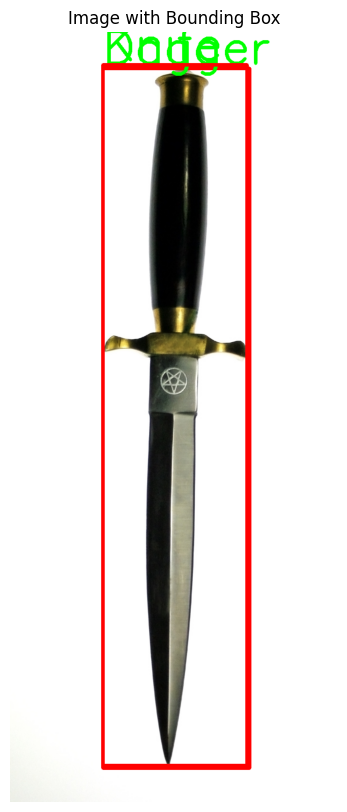

Image: (1200, 1600, 3)
Coordinates: (109, 279), (1540, 1199)


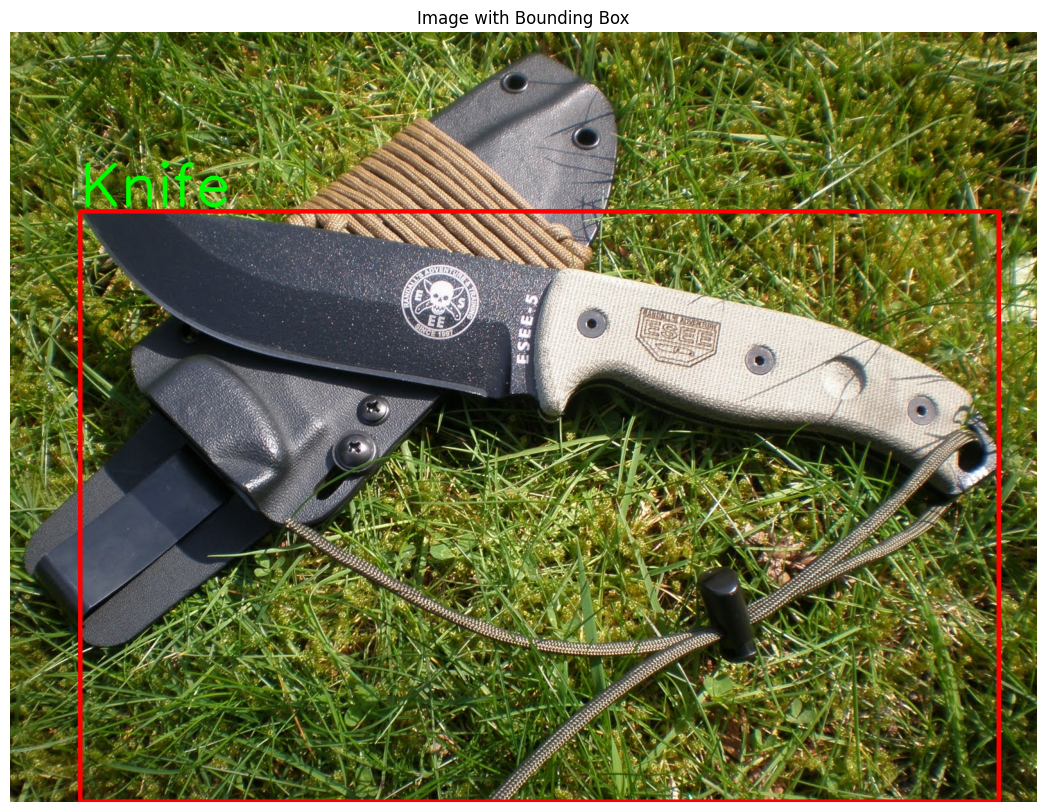

Image: (1365, 2048, 3)
Coordinates: (618, 445), (1405, 1363)
Coordinates: (1020, 222), (2046, 1363)
Coordinates: (463, 569), (1166, 797)
Coordinates: (835, 551), (1838, 877)
Coordinates: (472, 576), (1162, 796)
Coordinates: (834, 568), (1847, 875)
Coordinates: (724, 533), (1272, 781)
Coordinates: (962, 912), (1390, 1363)
Coordinates: (1109, 423), (2046, 1128)
Coordinates: (1639, 1193), (2046, 1363)


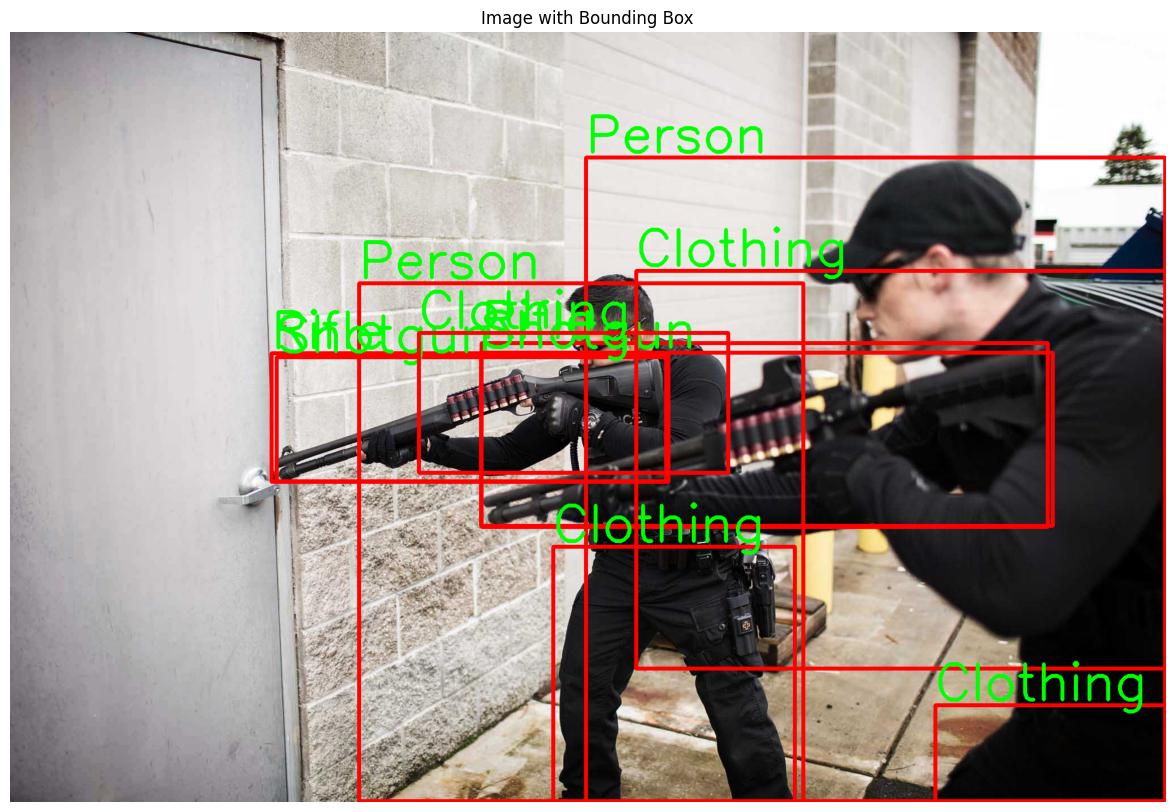

Image: (900, 1200, 3)
Coordinates: (78, 169), (1118, 829)


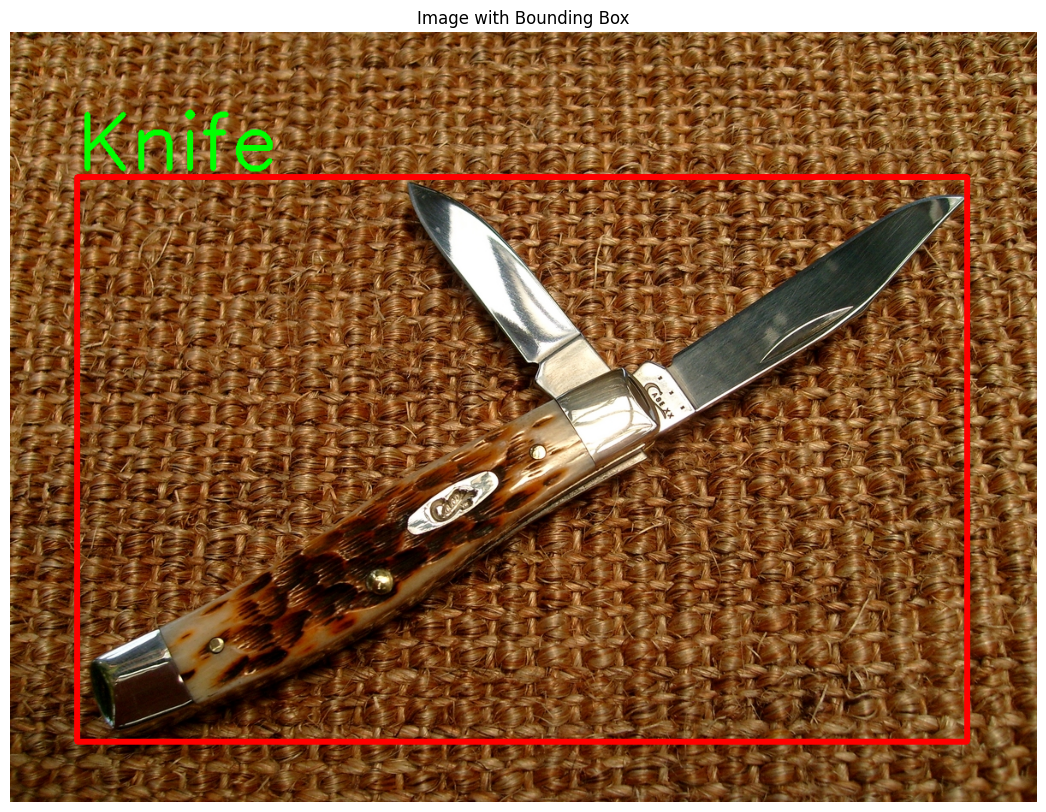

In [46]:
for img_id in train_img_ids:
  plot_bbox(img_id)

**This looks fine to me!!**

In [49]:
val_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# find boxes in each image and put them in a dataframe
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]

for i in range(len(test_imgs)):
    sys.stdout.write('Parse test_imgs ' + str(i) + '; Number of boxes: ' + str(len(val_df)) + '\r')
    sys.stdout.flush()
    img_name = test_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                df_to_append = pd.DataFrame({'FileName': [img_name],
                                            'XMin': [row['XMin']],
                                            'XMax': [row['XMax']],
                                            'YMin': [row['YMin']],
                                            'YMax': [row['YMax']],
                                            'ClassName': [classes[i]]})
                val_df = pd.concat([val_df, df_to_append], ignore_index=True)

In [50]:
train_df.to_csv('train.csv')
val_df.to_csv('test.csv')

### Write train.csv to annotation.txt

In [56]:
train_df = pd.read_csv('train.csv')

# for training
with open("annotation.txt", "w+") as f:
    for idx, row in train_df.iterrows():
        img_path = '/content/drive/MyDrive/train01/' + row['FileName']
        img = cv2.imread(img_path)
        if img is None:
            print(f"Image at {img_path} could not be read.")
            continue
        height, width = img.shape[:2]
        x1 = int(row['XMin'] * width)
        x2 = int(row['XMax'] * width)
        y1 = int(row['YMin'] * height)
        y2 = int(row['YMax'] * height)

        google_colab_file_path = '/content/drive/MyDrive/train01'
        fileName = os.path.join(google_colab_file_path, row['FileName'])
        className = row['ClassName']
        f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

Image at /content/drive/MyDrive/train01/6ef251c7d86614a3.jpg could not be read.


In [58]:
test_df = pd.read_csv('test.csv')

# for test
with open("test_annotation.txt", "w+") as f:
    for idx, row in test_df.iterrows():
        sys.stdout.write(str(idx) + '\r')
        sys.stdout.flush()
        img_path = '/content/drive/MyDrive/test01/' + row['FileName']
        img = cv2.imread(img_path)
        if img is None:
            print(f"Image at {img_path} could not be read.")
            continue
        height, width = img.shape[:2]
        x1 = int(row['XMin'] * width)
        x2 = int(row['XMax'] * width)
        y1 = int(row['YMin'] * height)
        y2 = int(row['YMax'] * height)

        google_colab_file_path = '/content/drive/MyDrive/train01'
        fileName = os.path.join(google_colab_file_path, row['FileName'])
        className = row['ClassName']
        f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

Image at /content/drive/MyDrive/test01/4b32b4251f8e3145.jpg could not be read.
